<a href="https://colab.research.google.com/github/ask350/UM-Projects/blob/main/Heart%20Disease/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Heart Disease model

In [1]:
# 1 - import libraries

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
# 2 - import data

url = "https://drive.google.com/file/d/1RbIeu1De0DhGT5ypKkJIJikpN4FO2uKF/view?usp=drive_link"
output = "heart.csv"
gdown.download(url, output, quiet=False, fuzzy=True)

df = pd.read_csv(output)
print("Dataset Shape:", df.shape)
df.head()

Downloading...
From: https://drive.google.com/uc?id=1RbIeu1De0DhGT5ypKkJIJikpN4FO2uKF
To: /content/heart.csv
100%|██████████| 39.7k/39.7k [00:00<00:00, 41.9MB/s]

Dataset Shape: (1190, 12)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0



Class Distribution:
target
1    629
0    561
Name: count, dtype: int64


/tmp/ipython-input-873342910.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette="coolwarm")


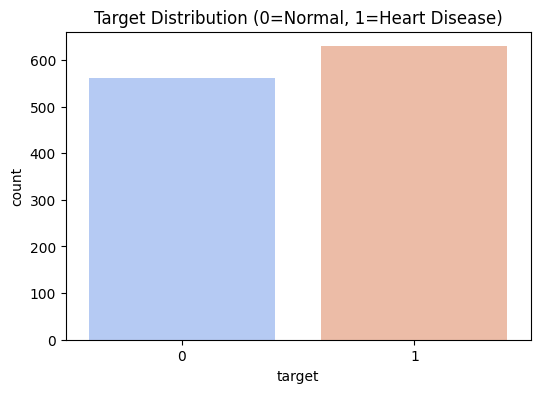

In [3]:
# 3 - EDA

print("\nClass Distribution:")
print(df['target'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df, palette="coolwarm")
plt.title("Target Distribution (0=Normal, 1=Heart Disease)")
plt.show()

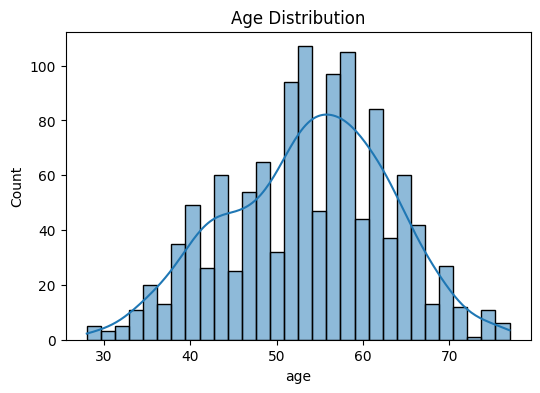

In [4]:
# 3 - Age distribution

plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

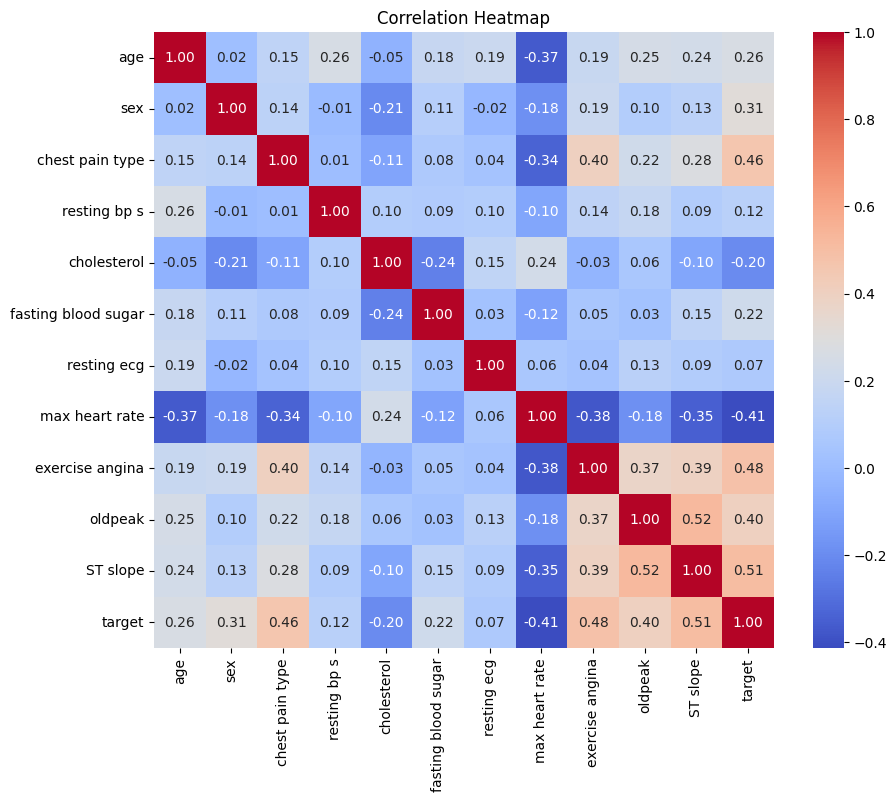

In [5]:
# 3 - Correlation heatmap

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [6]:
# 4 - Preprocessing

# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# Identify categorical features to one-hot encode
categorical_cols = ["chest pain type", "resting ecg", "ST slope"]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
num_cols = ["age", "resting bp s", "cholesterol", "max heart rate", "oldpeak"]
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (952, 16) Test shape: (238, 16)


In [7]:
# 5 - Model Training

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:05:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model Performance:

                     Accuracy  Precision    Recall  F1-score   ROC-AUC
Logistic Regression  0.861345   0.854962  0.888889  0.871595  0.931193
Random Forest        0.911765   0.933884  0.896825  0.914980  0.977289
XGBoost              0.924370   0.935484  0.920635  0.928000  0.967687

Best Model Based on ROC-AUC: Random Forest


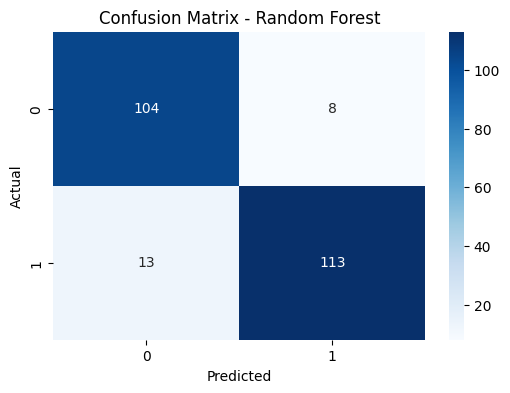

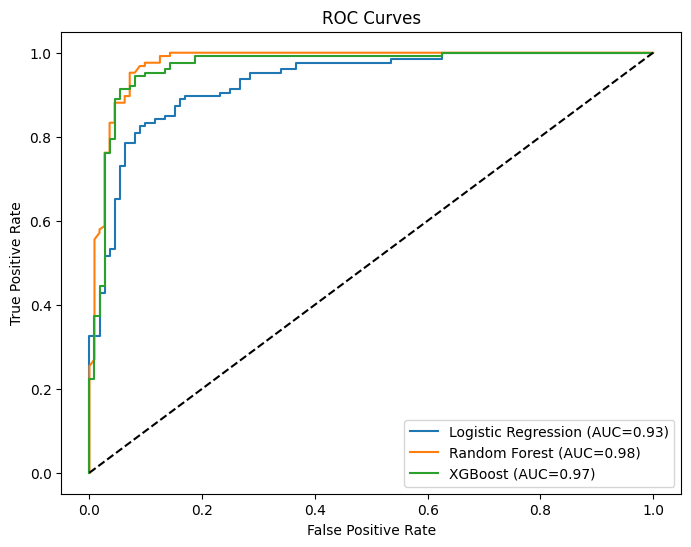

In [8]:
# 6 - Evaluation

results_df = pd.DataFrame(results).T
print("\nModel Performance:\n")
print(results_df)

# Confusion Matrix for best model
best_model_name = results_df['ROC-AUC'].idxmax()
print(f"\nBest Model Based on ROC-AUC: {best_model_name}")

best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# ROC Curves
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [9]:
# 7 - Final Statement

print("===== FINAL STATEMENT =====")
print(f"The best performing model for predicting heart disease is **{best_model_name}**,")
print("achieving strong results with high recall (catching patients with disease is crucial).")
print("This model can assist in preliminary screening, but should be used with medical expertise.")

===== FINAL STATEMENT =====
The best performing model for predicting heart disease is **Random Forest**,
achieving strong results with high recall (catching patients with disease is crucial).
This model can assist in preliminary screening, but should be used with medical expertise.


In [10]:
# 8 - Hypothetical Case Prediction

# Example: 55-year-old male, chest pain type=2, resting bp=140, cholesterol=250, etc.
hypothetical_patient = {
    "age": 55,
    "sex": 1,  # 1=male
    "chest pain type": 2,
    "resting bp s": 140,
    "cholesterol": 250,
    "fasting blood sugar": 0,
    "resting ecg": 1,
    "max heart rate": 150,
    "exercise angina": 0,
    "oldpeak": 1.5,
    "ST slope": 2
}

# Convert to dataframe
patient_df = pd.DataFrame([hypothetical_patient])

# One-hot encode categorical features
patient_df = pd.get_dummies(patient_df, columns=categorical_cols, drop_first=True)

# Add any missing columns (from training data)
for col in X.columns:
    if col not in patient_df.columns:
        patient_df[col] = 0

# Ensure correct column order
patient_df = patient_df[X.columns]

# Scale numeric features
patient_df[num_cols] = scaler.transform(patient_df[num_cols])

# Prediction using best model
prediction = best_model.predict(patient_df)[0]
probability = best_model.predict_proba(patient_df)[0][1]

print("HYPOTHETICAL CASE RESULT")
if prediction == 1:
    print(f"Prediction: Patient has HEART DISEASE (Probability={probability:.2f})")
else:
    print(f"Prediction: Patient is NORMAL (Probability={1-probability:.2f})")


HYPOTHETICAL CASE RESULT
Prediction: Patient is NORMAL (Probability=0.62)


In [11]:
# 9 - Optional: Manual Input for Prediction

print("Enter patient details below:")

age = int(input("Age: "))
sex = int(input("Sex (0=female, 1=male): "))
chest_pain = int(input("Chest Pain Type (1=typical angina, 2=atypical angina, 3=non-anginal, 4=asymptomatic): "))
bp = int(input("Resting BP (mm Hg): "))
chol = int(input("Cholesterol (mg/dl): "))
fbs = int(input("Fasting Blood Sugar (0=<120mg/dL, 1=>120mg/dL): "))
ecg = int(input("Resting ECG (0=normal,1=ST-T abnormal,2=LVH): "))
max_hr = int(input("Max Heart Rate: "))
ex_angina = int(input("Exercise Angina (0=no, 1=yes): "))
oldpeak = float(input("Oldpeak (ST depression): "))
slope = int(input("ST Slope (1=up, 2=flat, 3=down): "))

manual_patient = {
    "age": age, "sex": sex, "chest pain type": chest_pain,
    "resting bp s": bp, "cholesterol": chol, "fasting blood sugar": fbs,
    "resting ecg": ecg, "max heart rate": max_hr, "exercise angina": ex_angina,
    "oldpeak": oldpeak, "ST slope": slope
}

manual_df = pd.DataFrame([manual_patient])
manual_df = pd.get_dummies(manual_df, columns=categorical_cols, drop_first=True)

# Add missing cols
for col in X.columns:
    if col not in manual_df.columns:
        manual_df[col] = 0

manual_df = manual_df[X.columns]
manual_df[num_cols] = scaler.transform(manual_df[num_cols])

manual_pred = best_model.predict(manual_df)[0]
manual_prob = best_model.predict_proba(manual_df)[0][1]

print("===== MANUAL INPUT RESULT =====")
if manual_pred == 1:
    print(f"Prediction: Patient has HEART DISEASE (Probability={manual_prob:.2f})")
else:
    print(f"Prediction: Patient is NORMAL (Probability={1-manual_prob:.2f})")

Enter patient details below:
Age: 40
Sex (0=female, 1=male): 1
Chest Pain Type (1=typical angina, 2=atypical angina, 3=non-anginal, 4=asymptomatic): 2
Resting BP (mm Hg): 60
Cholesterol (mg/dl): 45
Fasting Blood Sugar (0=<120mg/dL, 1=>120mg/dL): 0
Resting ECG (0=normal,1=ST-T abnormal,2=LVH): 0
Max Heart Rate: 170
Exercise Angina (0=no, 1=yes): 0
Oldpeak (ST depression): 2
ST Slope (1=up, 2=flat, 3=down): 1
===== MANUAL INPUT RESULT =====
Prediction: Patient has HEART DISEASE (Probability=0.62)


In [12]:
# 10 Save Model and Scaler

import joblib
import json

# Save the model
joblib.dump(best_model, "heart_disease_model.pkl")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Save feature columns for consistent order
with open("feature_columns.json", "w") as f:
    json.dump(list(X.columns), f)

print("Model, scaler, and feature column info saved successfully!")

Model, scaler, and feature column info saved successfully!
